# CREDIT DEFAULT - MLII (MAP 569)
**Alexander Davi & Félix Chalumeau**

In [246]:
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tqdm

import datetime

%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics

# Introduction

### The data set
We are provided a dataset about credit default. It contains 5380 raws, each described by 19 features. Those features are of different types, amongst them are date values, numeric values and categorical values. 
We are going to see how to handle each of them as well as how to manage the NaN and unfeasible values in this dataset in order to be able to model it afterwards. 

### The problem
This problem is a tabular one with a classification task. It is quite particular as the data seems unbalanced. We will try to resample it or we will use an appropriate model for this use case. 

### Our plan
First, we are going to explore the data and infere transformations from our observations. Then we will design our pipeline. We will split the dataset in three parts: train, validation, test. The test set will be only used at the very end of our work to make sure we have not overfitted the validation set ! 
We will then try different models, choose the most promising one and tune some of its hyperparameters. 
We will finally conclude by analysing our final performance on the test set and our features importance. 

### Our metrics
To measure the performance of our model, we will use accuracy and ROC AUC score, which are common metrics for classification tasks.

# 1. Exploration and transformation of the data

## 1.1. A first glance at the data 

In [247]:
data = pd.read_csv('data/CreditTraining.csv', parse_dates=[3, 4, 13, 17])
data.head(5)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


We can already delete the Id_Customer feature, which is a identification variable, but this role is already taken by our index, hence we have no reason to keep this value.

In [248]:
data = data.drop(columns=['Id_Customer'])

### Another quick little fix

The feature Net_Annual_Income is not considered as a float but as a string. To do so, we need to replace the ',' in '.' and then to convert the string to a float.

In [249]:
data['Net_Annual_Income'] = data['Net_Annual_Income'].str.replace(',', '.').astype(float)

## 1.2. Let's look at the target value 

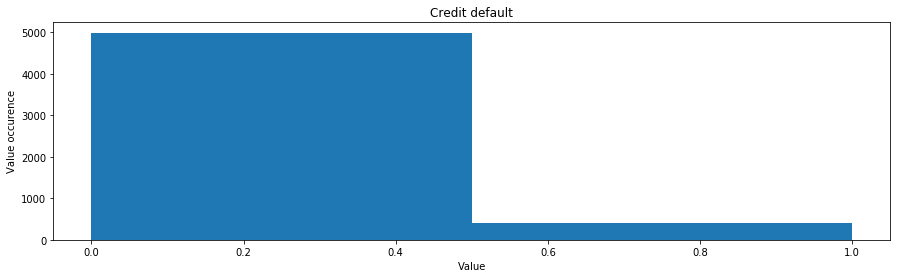

In [250]:
fig = plt.figure(figsize=(15, 4))
plt.hist(data['Y'], bins = 2)
plt.title("Credit default")
plt.ylabel('Value occurence')
plt.xlabel("Value")
# plt.grid()
plt.show()

We can see that the **data is very unbalanced**. Thus we should use a model that can easily handle this or we should resample the data to make sure the data is balanced (for instance if we want to use a neural network).

## 1.3. Handle the date values

Here we will not treat data as time series, the timestamp is not interesting in itself, but time deltas are interesting in our use case, we are going to make those timestamps timedeltas and divise them by a time unit to convert them to floats !

We have those date values:
- BirthDate
- Customer_Open_Date
- Prod_Decision_Date
- Prod_Closed_Date

Here are the feature that we are going to create:


- Cusomer_Open_Date is taken as the difference in days between the latest Customer_Open_Date and the current one. Thus, we will have a positive count of days.
- Rather than considering the BirthDate, it seems more logical to consider the age at the time when the desision is taken (ie. Prod_Decision_Date). To do that, we will count the amount of days the customer has lived when the Decision is taken.
- The Prod_Decision_Date is taken as the difference in days with the latest one.
- We will proceed in the same way with Prod_Closed_Date

In [251]:
ONE_DAY = datetime.timedelta(days = 1)

In [252]:
# open date
data['Customer_Open_Date'] = (data['Customer_Open_Date'].max() - data['Customer_Open_Date']) / ONE_DAY
# birthdate 
# data['BirthDate'] = (data['Prod_Decision_Date'] - data['BirthDate']) / ONE_DAY
data['BirthDate'] = (data['Prod_Decision_Date'].max() - data['BirthDate']) / ONE_DAY
# prod decision date
data['Prod_Decision_Date'] = (data['Prod_Decision_Date'].max() - data['Prod_Decision_Date']) / ONE_DAY

As they seem to be a huge correlation between the feature Prod_Closed_Date and the credit default, the high number of NaN is not sufficient at all to delete it ! We just replace them with 0.

In [253]:
data['Prod_Closed_Date'] = (data['Prod_Closed_Date'].max() - data['Prod_Closed_Date']) / ONE_DAY
data['Prod_Closed_Date'] = data['Prod_Closed_Date'].fillna(0)

## 1.4. Let's explore the continuous features

We draw histograms for the continuous variables, see if we observe anything, maybe outliers...

### 1.4.1. Visualisation

In [254]:
CONTINUOUS_FEATURES = {
    'BirthDate': 100,
    'Customer_Open_Date': 100,
    'Number_Of_Dependant': 20,
    'Years_At_Residence': 60,
    'Net_Annual_Income': 100,
    'Years_At_Business': 100,
    'Prod_Decision_Date': 70,
    'Nb_Of_Products': 3,
    'Prod_Closed_Date': 30
}

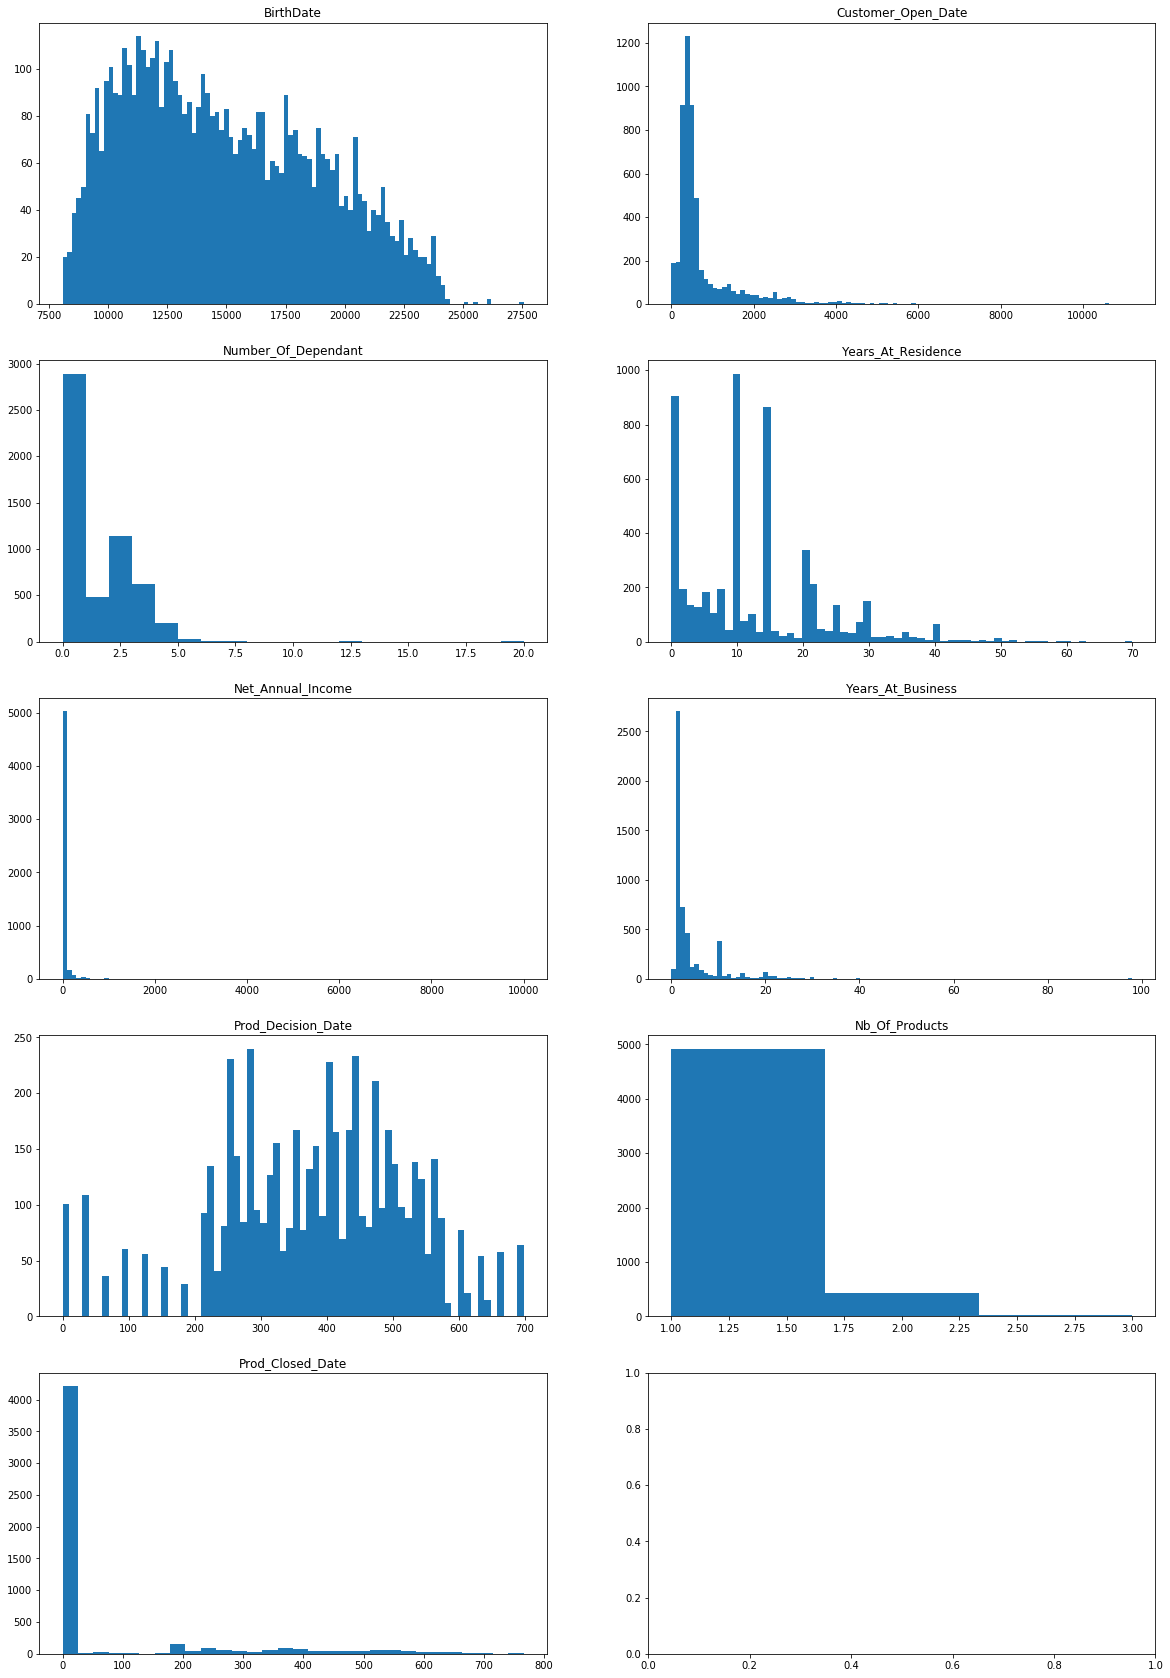

In [255]:
N = len(CONTINUOUS_FEATURES.keys())
Nx = N // 2 + N % 2

fig, axs = plt.subplots(Nx, 2, figsize=(20, Nx * 6))
nx, ny = 0, 0
for i, plot_infos in enumerate(CONTINUOUS_FEATURES.items()):
    feature, n_bins = plot_infos
    
    # manage plot
    axs[nx, ny].hist(data[feature], bins = n_bins)
    axs[nx, ny].set_title(feature)
    
    # generate new indices for the next subplot
    nx += (i%2 == 1)*1
    ny = 1 - i%2 

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
    
plt.show()

### 1.4.2 Analysis

These graphs allow us to make some precious observations, which will lead us to modify slightly the data. 

- Concerning the number of Years_At_Business, there seems to be some strange values, around 100, which are not feasible. We will replace these values by mean(Years_At_Business).

- We can observe a similar phenomenon for Customer_Open_Date, which is around 10000 days, meaning around 30 years. We will leave these values as they are feasible.

- For the Years_At_Residence variable, it is interesting to realise that we have wery high peaks around 10,20,30 years, as if the customers gave approximate answers for this data. This meansthat the data is somewhat unbalanced and not smoothly dispatched. This might be a problem for some models, such as logistic regression. However, other models such as decision trees and XGBOOST, which we will use, are unbothered by such issues. We will not modify this aspect of the data. 

### 1.4.3 Removing the outliers

**Modify unfeasible data**:
You cannot spend more years in a residence or working than you spent years on the earth... which is why we make sure that all the values are feasible, and if they are not, we replace them by feasible values ! Instead of taking the mean value, we use a approximate linear regression, saying that it is equal to 1 x Age + constant, with constant being 18 or 22.

In [256]:
# mean = data['Years_At_Business'].mean()
# data['Years_At_Business'].loc[data['Years_At_Business'] > 95] = mean

In [257]:
data['Age'] = (data['BirthDate']) / (365)

In [258]:
for i in tqdm(range(data.shape[0])):
   diff_res = data['Age'][i] - data['Years_At_Residence'][i]
   diff_bus = data['Age'][i] - data['Years_At_Business'][i]
   if (diff_res < 0):
       data['Years_At_Residence'][i] = max(1, data['Age'][i] - 18)
   if (diff_bus < 10):
       data['Years_At_Business'][i] = max(1, data['Age'][i] - 22)

100%|██████████| 5380/5380 [00:00<00:00, 13485.99it/s]


In [259]:
data = data.drop(columns=['Age'])

### 1.4.3. Handle NaN values
We search were the NaN are.

In [260]:
data.isna().sum()

Y                      0
Customer_Type          0
BirthDate              0
Customer_Open_Date     0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    2
Years_At_Residence     0
Net_Annual_Income      2
Years_At_Business      2
Prod_Sub_Category      0
Prod_Decision_Date     0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Closed_Date       0
Prod_Category          0
dtype: int64

For the unfeasible data, we replaced absurd values thanks to a quick approximation of a linear regression. Here we can hardly do this, hence we simply replace the NaN values with the mean of the feature. 

In [261]:
nb_dep = data['Number_Of_Dependant'].mean()
data[data['Number_Of_Dependant'].isna()]

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
634,1,Existing Client,8187.0,806.0,P_Client,University,Single,NaN,21,33.6,1.0,C,230.0,Branch,Owned,2,249.0,G
5045,0,Existing Client,22857.0,2999.0,NP_Client,Master/PhD,Married,NaN,10,50.0,10.0,C,222.0,Sales,Owned,1,0.0,B


In [262]:
data['Number_Of_Dependant'][634] = nb_dep
data['Number_Of_Dependant'][5045] = nb_dep

In [263]:
annual_inc = data['Net_Annual_Income'].mean()
# data[data['Net_Annual_Income'].isna()]
data['Net_Annual_Income'][1879] = annual_inc
data['Net_Annual_Income'][5144] = annual_inc

Except for the Years_At_Business were we use the same trick as before !

In [264]:
# data[data['Years_At_Business'].isna()]
data['Years_At_Business'][1987] = (data['BirthDate'][1987] / (365)) - 22
data['Years_At_Business'][2750] = (data['BirthDate'][2750] / (365)) - 22

In [265]:
# in case there is an issue 
data = data.fillna(value=0)

## 1.5. Let's explore the discrete features

### 1.5.1. Visualisation

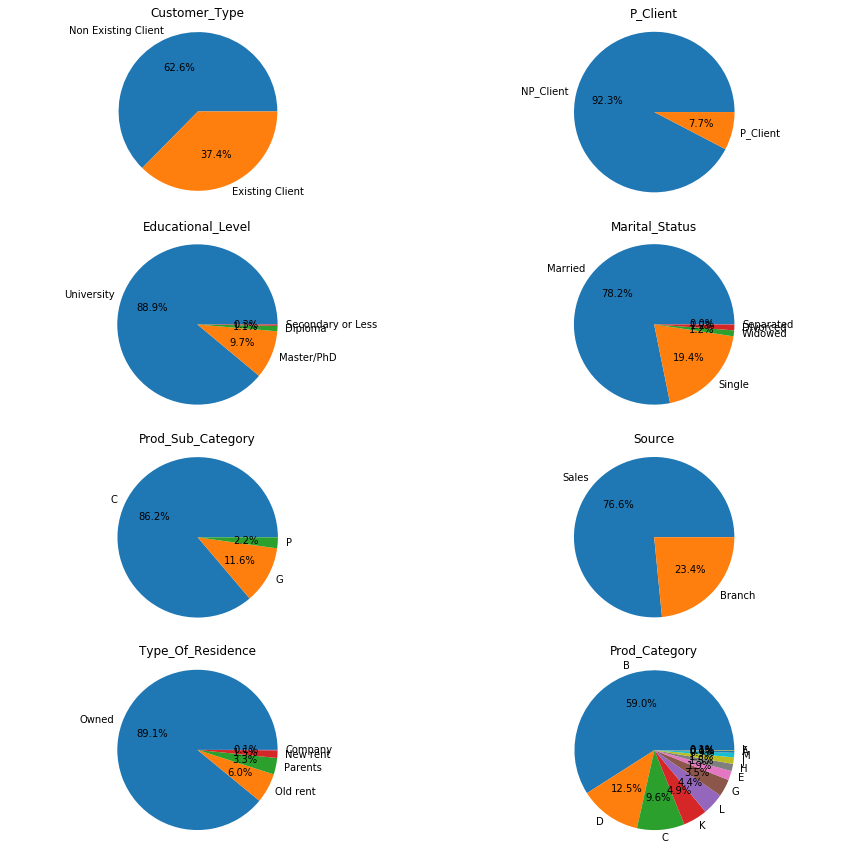

In [266]:
Categorical_Values = ['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status','Prod_Sub_Category',
                     'Source', 'Type_Of_Residence', 'Prod_Category']

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i in range(len(Categorical_Values)):
    cat = Categorical_Values[i]
    serie = data[cat].value_counts()
    labels = list(serie.index.values)
    sizes = list(serie.values)
    
    axs[i//2,i%2].pie(serie, labels = labels,autopct='%1.1f%%')
    axs[i//2,i%2].set_title(cat)
    axs[i//2,i%2].axis('equal')
    
plt.show()  

We also look at a description of everything we have in categorical variables (except dates) to see the distribution of what we have.

### 1.5.2. Analysis - Model Selection

There seems to be quite a large amount  of categories here, maby we can try to regroup some together, in order to have a simpler model.

Lets take a look at the Category Marital_Status in more detail :

In [267]:
Marital_Categories = ['Married',  'Single', 'Widowed', 'Separated', 'Divorced']
for let in Marital_Categories:
    print('------------------------------------------------------')
    print('Category '+ let)
    
    serie = data.loc[data['Marital_Status'] == let]['Y'].value_counts()
    
    print('Percent of negatives : ' + str((1 - serie[0]/serie.sum())*100))
    print('Size of category : '+ str(serie.sum()))

------------------------------------------------------
Category Married
Percent of negatives : 6.9186875891583455
Size of category : 4206
------------------------------------------------------
Category Single
Percent of negatives : 8.891013384321223
Size of category : 1046
------------------------------------------------------
Category Widowed
Percent of negatives : 6.25
Size of category : 64
------------------------------------------------------
Category Separated
Percent of negatives : 0.0
Size of category : 1
------------------------------------------------------
Category Divorced
Percent of negatives : 7.936507936507942
Size of category : 63


The category 'Separated' seems of very little importance considering its size. We will regroup it with the 'Divorced' category as they are semantically similar.

In [268]:
data['Marital_Status'].loc[data['Marital_Status'] == 'Separated'] = 'Separated_Or_Divorced'
data['Marital_Status'].loc[data['Marital_Status'] == 'Divorced'] = 'Separated_Or_Divorced'

When running our model whilst testing, we found out that quite a few categories of Prod_Category turned out having an extremely weak feature importance. For this reason, we regrouped them in a class called 'Regrouping_Class', allowing us to simplify the model.

In [269]:
data['Prod_Category'].loc[data['Prod_Category'] == 'A'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'E'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'F'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'G'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'I'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'J'] = 'Regrouping_Class'


These previous manipulations have allowed us to simplify the model. If we wonsider indicators such as BIC, these would now have a better value.

### 1.5.3. Label Encoding 


For some variables, we will simply use label encoding. The easiest is to apply label encoding to any categorical variable with only two levels. For these, there is no need to use One-Hot encoding.

In [270]:
le = LabelEncoder()
le.fit(data['Customer_Type'])

LabelEncoder()

In [271]:
list(le.classes_)

['Existing Client', 'Non Existing Client']

In [272]:
le.transform(data['Customer_Type']) 

array([1, 0, 1, ..., 1, 1, 1])

In [273]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### 1.5.4. One Hot Encoding 

For the other variables, there exists a pandas function that allows us to create One Hot encoding immediately.

In [274]:
data = pd.get_dummies(data)

## 1.6. A last glance at our preprocessed dataset 

In [275]:
data.head()

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Decision_Date,...,Type_Of_Residence_Owned,Type_Of_Residence_Parents,Prod_Category_B,Prod_Category_C,Prod_Category_D,Prod_Category_H,Prod_Category_K,Prod_Category_L,Prod_Category_M,Prod_Category_Regrouping_Class
0,0,1,12933.0,295.0,0,3.0,1,36.0,1.0,294.0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,14054.0,1342.0,1,0.0,12,18.0,2.0,523.0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,14391.0,275.0,0,2.0,10,36.0,1.0,244.0,...,1,0,1,0,0,0,0,0,0,0
3,1,0,11077.0,467.0,0,3.0,3,36.0,1.0,514.0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,21658.0,64.0,0,2.0,1,36.0,1.0,33.0,...,1,0,0,0,1,0,0,0,0,0


# 2. Data scale and split 

## 2.1. Split the data: train, validate, test

....

In [276]:
features_name = data.columns[1:]
y, X = data[['Y']].values[:,0], data[features_name].values

In [277]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)

In [278]:
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.07319198373511472, 0.06736353077816493, 0.07713754646840149)

## 2.2. Fit the scaler on the train data

In [279]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [280]:
X_train

array([[1.0000e+00, 1.1775e+04, 3.0700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 9.6780e+03, 5.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 2.0380e+04, 1.2200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 9.8340e+03, 4.8700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.4493e+04, 2.2700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.8087e+04, 9.3400e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [281]:
# transform train and validate 
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

# 3. Comparison of different models 

Let's fit a few models and compare the performance 

In [282]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

## 3.1. Use a Logistic Regression

In [283]:
model1 = LogisticRegression()
model1.fit(X_train_s, y_train)

y_train_pred = model1.predict(X_train_s)
y_train_predprob = model1.predict_proba(X_train_s)[:,1]

y_val_pred = model1.predict(X_val_s)
y_val_predprob = model1.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9459773453383677
ROC AUC (Train):         0.9316057562688713

 --- VALIDATE
Accuracy :               0.9454123112659698
ROC AUC (Validate):      0.9195044445398721


## 3.2. Use a Decision Tree Classifier

In [284]:
model2 = DecisionTreeClassifier(random_state=0, max_depth=5)
model2.fit(X_train_s, y_train)

y_train_pred = model2.predict(X_train_s)
y_train_predprob = model2.predict_proba(X_train_s)[:,1]

y_val_pred = model2.predict(X_val_s)
y_val_predprob = model2.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9546906767354052
ROC AUC (Train):         0.9526445906890908

 --- VALIDATE
Accuracy :               0.9407665505226481
ROC AUC (Validate):      0.9504122471765363


## 3.3. Use a XGBoost Classifier

In [285]:
# use xgboost 
model3 = xgb.XGBClassifier(n_estimators = 50)

model3.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = model3.predict(X_train_s)
y_train_predprob = model3.predict_proba(X_train_s)[:,1]

y_val_pred = model3.predict(X_val_s)
y_val_predprob = model3.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9575951205344176
ROC AUC (Train):         0.9644921480552945

 --- VALIDATE
Accuracy :               0.9547038327526133
ROC AUC (Validate):      0.9522265641774381


# 4. Tuning of the model 
XGBoost is known as a very consistent model. Many of its hyperparameters do not need a lot of tuning. Nevertheless, the number of estimators is the one that can have a big influence on the final performance of the model. Let's tune it. 

In [286]:
N_ESTIMATORS_RANGE = [10, 20, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200]
train_scores = []
validate_scores = []

for n_estim in tqdm_notebook(N_ESTIMATORS_RANGE):
    model = xgb.XGBClassifier(n_estimators = n_estim)
    model.fit(X_train_s, y_train)

    # Predict training and validation set:
    y_train_predprob = model.predict_proba(X_train_s)[:,1]
    y_val_predprob = model.predict_proba(X_val_s)[:,1]

    train_scores.append(metrics.roc_auc_score(y_train, y_train_predprob))
    validate_scores.append(metrics.roc_auc_score(y_val, y_val_predprob))

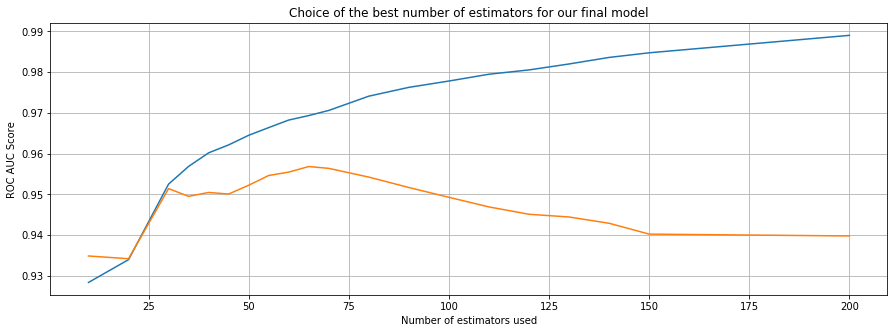

In [287]:
fig = plt.figure(figsize=(15, 5))

plt.plot(N_ESTIMATORS_RANGE, train_scores)
plt.plot(N_ESTIMATORS_RANGE, validate_scores)

plt.title("Choice of the best number of estimators for our final model")
plt.ylabel('ROC AUC Score')
plt.xlabel("Number of estimators used")

plt.grid()
plt.show()

We were previously working with n_estimators = 50. This plot shows that we could reduce overfitting with a choice of **n_estimators = 30**. Hence we now run our new model, which is the final one !

### Let's train our final model with the new hyper parameter. 


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9541097879756026
ROC AUC (Train):         0.9525077972273209

 --- VALIDATE
Accuracy :               0.9535423925667829
ROC AUC (Validate):      0.9513999227036545



 			----------------------------- Feature Importances -----------------------------


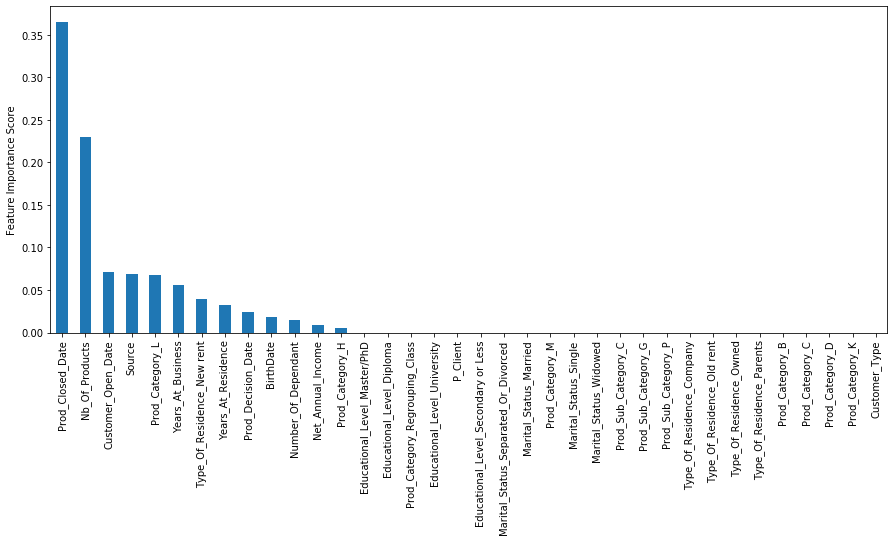

In [288]:
# use xgboost
final_model = xgb.XGBClassifier(n_estimators = 30)

final_model.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = final_model.predict(X_train_s)
y_train_predprob = final_model.predict_proba(X_train_s)[:,1]

y_val_pred = final_model.predict(X_val_s)
y_val_predprob = final_model.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))

print("\n\n\n \t\t\t----------------------------- Feature Importances -----------------------------")

feat_imp = pd.Series(final_model.feature_importances_, index=features_name).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(15, 6))
plt.ylabel('Feature Importance Score')
plt.show()

# 5. Conclusion 

To conclude, we will use our Test Set to make sure that our models are efficient classifiers. Our most effective model seems to be the XGBOOST model. Let's see how it performs on the Test Set, now that we have tuned the hyperparameters.

In [289]:
#Scaling the test set
X_test_s = scaler.transform(X_test)

In [290]:
y_test_pred = final_model.predict(X_test_s)
y_test_predprob = final_model.predict_proba(X_test_s)[:,1]

print("\n ---------------- Final Results ----------------")
print("\n --- TEST")
print("Accuracy :               {}".format(metrics.accuracy_score(y_test, y_test_pred)))
print("ROC AUC (Test):         {}".format(metrics.roc_auc_score(y_test, y_test_predprob)))


 ---------------- Final Results ----------------

 --- TEST
Accuracy :               0.9460966542750929
ROC AUC (Test):         0.9288270908407041


## Plotting the ROC curve

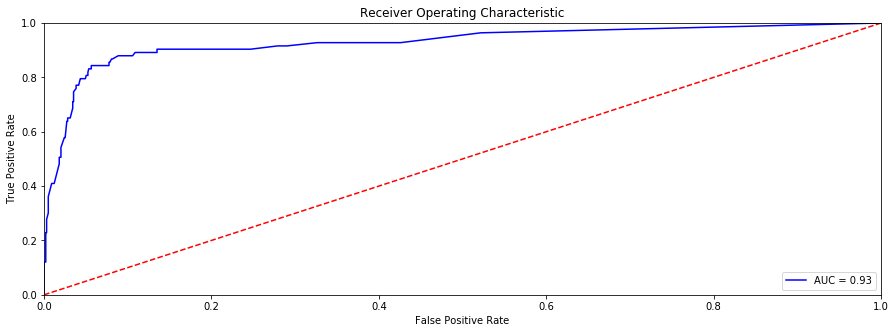

In [291]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_predprob)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(15, 5))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The way this ROC curve looks suggests an efficient model, meaning that the distribution curves of True Positives and True Negatives barely overlap.